In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
RX_pattern = np.load('data/RX_pattern.npy')
TX_pattern = np.load('data/TX_pattern.npy')
OMNI_pattern = np.load('data/OMNI_pattern.npy')
impulse_response = np.load('data/impulse_response.npy')
#print(impulse_response)

In [12]:
all_paths = impulse_response.shape[0]

for path_idx in range(all_paths):
    TX1 = int(impulse_response[path_idx][3])
    TX2 = int(impulse_response[path_idx][4])
    RX1 = int(impulse_response[path_idx][5])
    RX2 = int(impulse_response[path_idx][6])

    impulse_response[path_idx][1] = 20*np.log10(impulse_response[path_idx][1])
    impulse_response[path_idx][1] = impulse_response[path_idx][1] + TX_pattern[TX1][TX2] + OMNI_pattern[RX1][RX2]
    #impulse_response[path_idx][1] = impulse_response[path_idx][1] + TX_pattern[TX1][TX2] + RX_pattern[RX1][RX2]
    impulse_response[path_idx][1] = 10**(impulse_response[path_idx][1]/20)
    
#print(impulse_response)

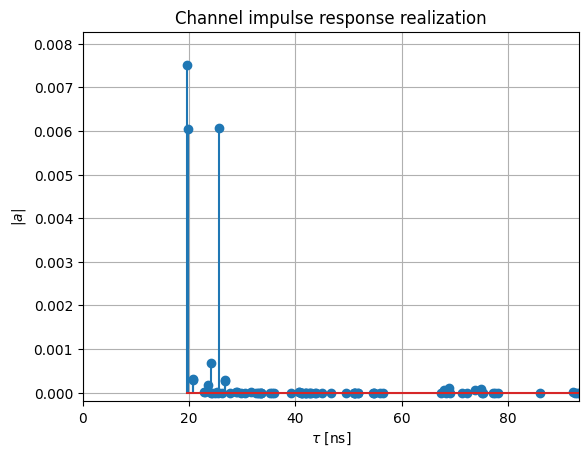

In [13]:
# And plot the CIR
a = impulse_response[:,1]
t = impulse_response[:,2]
t = t/1e-9

plt.figure()
plt.title("Channel impulse response realization")
plt.stem(t, a)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-4, np.max(a)*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");
plt.grid()

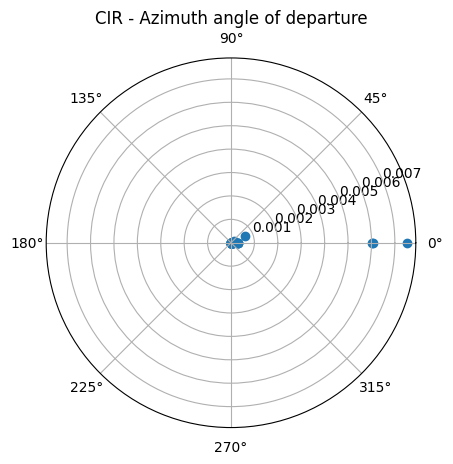

In [14]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(impulse_response[:,4]*np.pi/180, impulse_response[:,1])
ax.set_title("CIR - Azimuth angle of departure")
ax.grid(True)
plt.show()

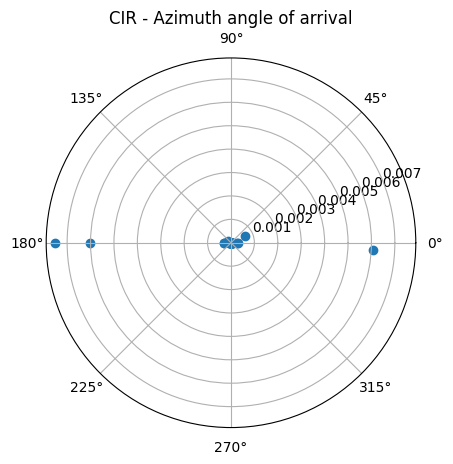

In [15]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(impulse_response[:,6]*np.pi/180, impulse_response[:,1])
ax.set_title("CIR - Azimuth angle of arrival")
ax.grid(True)
plt.show()

In [16]:
# Define parameters
num_tx_antennas = 1  # Number of transmit antennas
num_rx_antennas = 1  # Number of receive antennas
num_beams = 10  # Number of beams in the codebook

# Generate a sample codebook with beams as phase shifts
def generate_codebook(num_tx_antennas, num_beams):
    codebook = []
    for i in range(num_beams):
        phase_shift = np.exp(1j * 2 * np.pi * i / num_beams)  # Phase shift per beam
        beam = np.array([phase_shift ** n for n in range(num_tx_antennas)])
        codebook.append(beam / np.sqrt(num_tx_antennas))  # Normalize power
    return np.array(codebook)

# Generate the codebook
codebook = generate_codebook(num_tx_antennas, num_beams)

# Simulate an example channel matrix
channel = np.random.randn(num_rx_antennas, num_tx_antennas) + 1j * np.random.randn(num_rx_antennas, num_tx_antennas)

# Beamforming process: Evaluate each beam in the codebook
beam_scores = []
for beam in codebook:
    # Compute the beamformed signal by applying beam to the channel
    received_signal = np.dot(channel, beam)
    
    # Calculate the received power (signal strength)
    received_power = np.linalg.norm(received_signal) ** 2
    beam_scores.append(received_power)

# Select the best beam based on maximum received power
best_beam_index = np.argmax(beam_scores)
best_beam = codebook[best_beam_index]

print(f"Best beam index: {best_beam_index}")
print(f"Best beam vector: {best_beam}")
print(f"Maximum received power: {beam_scores[best_beam_index]}")

Best beam index: 0
Best beam vector: [1.+0.j]
Maximum received power: 1.6287917649841206
